# EcoDRR

**This file is a ready-to-run notebook** *once you provide the exported GeoTIFF files* (from Google Earth Engine or other sources) and adjust the file paths below.


**How to use:**
1. Export DEM, precipitation (CHIRPS), NDVI (recent & historic) and landcover (UNet result) from Google Earth Engine to Google Drive or Cloud Storage.
2. Download the TIFFs to this runtime and set the file paths in the `DATA PATHS` cell.
3. Run the notebook cells in order.

In [ ]:
!pip install rasterio numpy matplotlib scipy geemap earthengine-api scikit-image richdem

In [ ]:
!pip install rasterio

In [4]:
# 1 — Imports (run once)
import os
import numpy as np
import rasterio
from rasterio.warp import transform_bounds, calculate_default_transform, reproject, Resampling
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from rasterio.enums import Resampling as RioResampling
from rasterio.transform import Affine
print('Libraries imported. Note: if any import fails, install missing packages as instructed.')

Libraries imported. Note: if any import fails, install missing packages as instructed.


## 1 — DATA PATHS & NOTES

**Update the following file paths** to point to your downloaded GeoTIFFs (from GEE export):

- `dem_path`: NASADEM or other DEM (GeoTIFF)
- `precip_path`: CHIRPS or other precipitation raster (same units as used below, mm)
- `ndvi_recent_path`: Recent NDVI composite raster (values in -1..1 or 0..1)
- `ndvi_hist_path`: Historic NDVI composite raster
- `lc_path`: Landcover raster (UNet output; classes as integers)

Make sure TIFFs are in the same CRS (EPSG:4326 recommended) or the notebook will reproject/resample them to match the reference raster.

In [ ]:
# 2 — Update these file paths to the GeoTIFFs you've downloaded from GEE
dem_path = '/content/dem_export.tif'         # e.g. NASADEM exported via GEE to Drive -> downloaded here
precip_path = '/content/chirps_export.tif'   # e.g. CHIRPS daily/accumulation exported & downloaded
ndvi_recent_path = '/content/ndvi_recent_export.tif'
ndvi_hist_path = '/content/ndvi_hist_export.tif'
lc_path = '/content/landcover_unet.tif'

# Quick check
for p in [dem_path, precip_path, ndvi_recent_path, ndvi_hist_path, lc_path]:
    print(p, 'exists ->', os.path.exists(p))

print('\nIf files are missing, download them from Google Drive or place them at the paths above before running.')

/content/dem_export.tif exists -> True
/content/chirps_export.tif exists -> True
/content/ndvi_recent_export.tif exists -> True
/content/ndvi_hist_export.tif exists -> True
/content/landcover_unet.tif exists -> True

If files are missing, download them from Google Drive or place them at the paths above before running.


### Helper functions
This cell defines three key utilities:
- **load_raster**: reads a GeoTIFF and returns array + profile.
- **align_to_ref**: reprojects/resamples any raster to match a reference raster’s CRS, resolution, transform, and grid.
- **save_raster**: writes outputs as GeoTIFF with LZW compression.
These functions ensure consistent spatial alignment across DEM, NDVI, landcover, and precipitation.

In [ ]:
# 3 — Helper functions: load raster, align rasters to reference, save raster
def load_raster(path):
    '''Return (array, profile)'''
    with rasterio.open(path) as src:
        arr = src.read(1, masked=False).astype('float32')
        prof = src.profile.copy()
    return arr, prof


def align_to_ref(src_arr, src_prof, ref_prof, resampling=RioResampling.nearest):
    '''Reproject + resample src_arr/profile to match ref_prof (returns new_array, new_profile).'''
    dst_transform = ref_prof['transform']
    dst_width = ref_prof['width']
    dst_height = ref_prof['height']
    dst_crs = ref_prof['crs']

    dst = np.empty((dst_height, dst_width), dtype=src_arr.dtype)

    reproject(
        source=src_arr,
        destination=dst,
        src_transform=src_prof['transform'],
        src_crs=src_prof['crs'],
        dst_transform=dst_transform,
        dst_crs=dst_crs,
        resampling=resampling
    )
    new_prof = ref_prof.copy()
    return dst, new_prof


def save_raster(path, arr, prof):
    prof_out = prof.copy()
    prof_out.update(dtype=rasterio.float32, count=1, compress='lzw')
    with rasterio.open(path, 'w', **prof_out) as dst:
        dst.write(arr.astype(rasterio.float32), 1)
    print('Saved', path)

print('Helper functions ready.')

Helper functions ready.


### Load & align rasters
- This cell loads DEM first (the reference grid).
- Then it loads precipitation, NDVI recent, NDVI historic, and landcover, aligning each to match the DEM using **align_to_ref**.
- This guarantees identical pixel sizes, extents, and CRS — critical for pixel-wise computation.

In [ ]:
# 4 — Load DEM (reference) and align other rasters to it
try:
    dem, dem_prof = load_raster(dem_path)
except Exception as e:
    raise SystemExit('Could not open DEM. Set dem_path to the correct file. Error: ' + str(e))

# Use DEM as reference
ref_prof = dem_prof.copy()
ref_prof['dtype'] = 'float32'

print('DEM shape:', dem.shape)

# Load and align precipitation
if os.path.exists(precip_path):
    precip_raw, precip_prof = load_raster(precip_path)
    # Ensure CRS is present for reprojection if it's missing from the source profile
    if 'crs' not in precip_prof or precip_prof['crs'] is None:
        print(f"Warning: CRS missing in {precip_path}. Assuming reference CRS.")
        precip_prof['crs'] = ref_prof['crs']
    precip, precip_prof = align_to_ref(precip_raw, precip_prof, ref_prof, resampling=RioResampling.bilinear)
    print('Precip loaded and aligned:', precip.shape)
else:
    precip = None
    print('Precip not found; set precip_path and re-run.')

# Load and align NDVI rasters
ndvi_recent = None
ndvi_hist = None
if os.path.exists(ndvi_recent_path):
    nr, nr_prof = load_raster(ndvi_recent_path)
    if 'crs' not in nr_prof or nr_prof['crs'] is None:
        print(f"Warning: CRS missing in {ndvi_recent_path}. Assuming reference CRS.")
        nr_prof['crs'] = ref_prof['crs']
    ndvi_recent, _ = align_to_ref(nr, nr_prof, ref_prof, resampling=RioResampling.bilinear)
    print('NDVI recent loaded and aligned')
else:
    print('NDVI recent not found.')

if os.path.exists(ndvi_hist_path):
    nh, nh_prof = load_raster(ndvi_hist_path)
    if 'crs' not in nh_prof or nh_prof['crs'] is None:
        print(f"Warning: CRS missing in {ndvi_hist_path}. Assuming reference CRS.")
        nh_prof['crs'] = ref_prof['crs']
    ndvi_hist, _ = align_to_ref(nh, nh_prof, ref_prof, resampling=RioResampling.bilinear)
    print('NDVI historic loaded and aligned')
else:
    print('NDVI historic not found.')

# Load and align landcover (categorical -> use nearest resampling)
if os.path.exists(lc_path):
    lc_raw, lc_prof = load_raster(lc_path)
    if 'crs' not in lc_prof or lc_prof['crs'] is None:
        print(f"Warning: CRS missing in {lc_path}. Assuming reference CRS.")
        lc_prof['crs'] = ref_prof['crs']
    lc, _ = align_to_ref(lc_raw, lc_prof, ref_prof, resampling=RioResampling.nearest)
    lc = np.round(lc).astype(np.int32)
    print('Landcover loaded and aligned')
else:
    lc = None
    print('Landcover not found.')

# Quick checks
print('\nChecks:')
print('DEM min/max:', np.nanmin(dem), np.nanmax(dem))
if precip is not None:
    print('Precip min/max:', np.nanmin(precip), np.nanmax(precip))
if ndvi_recent is not None:
    print('NDVI recent min/max:', np.nanmin(ndvi_recent), np.nanmax(ndvi_recent))
if ndvi_hist is not None:
    print('NDVI hist min/max:', np.nanmin(ndvi_hist), np.nanmax(ndvi_hist))
if lc is not None:
    print('Landcover classes (unique):', np.unique(lc)[:20])

print('\nIf any of the variables are None, supply the missing files and re-run the corresponding cell.')

DEM shape: (151, 150)
Precip loaded and aligned: (151, 150)
NDVI recent loaded and aligned
NDVI historic loaded and aligned
Landcover loaded and aligned

Checks:
DEM min/max: -25.0 305.0
Precip min/max: 0.0 0.0
NDVI recent min/max: -0.1902058 0.8222394
NDVI hist min/max: -0.21042636 0.76449096
Landcover classes (unique): [1 2]

If any of the variables are None, supply the missing files and re-run the corresponding cell.


### Flood proxy
This cell computes a simple DEM‑derived flood susceptibility proxy:
1. Smooth DEM to remove noise.
2. Invert elevation (low areas → high flood potential).
3. Normalize 0–1.
The output is visualized for quick inspection.

Flood proxy computed. Range (min,max): 0.0 1.0


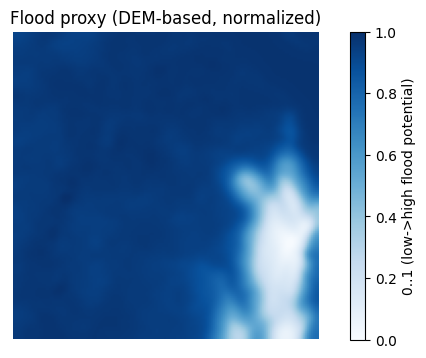

In [ ]:
# 5 — Flood proxy (simple DEM-based proxy)
# Explanation: Smooth the DEM to remove small noise, invert elevation (lower elevation -> higher proxy), normalize 0..1
sigma = 2  # smoothing parameter (increase to smooth more)
dem_s = gaussian_filter(dem, sigma=sigma)

flood_proxy = dem_s.max() - dem_s
# Mask nodata (if DEM uses 0 or negative for nodata, adjust accordingly) - we assume valid DEM values
flood_proxy = np.where(np.isfinite(dem), flood_proxy, np.nan)
# Normalize
flood_proxy = (flood_proxy - np.nanmin(flood_proxy)) / (np.nanmax(flood_proxy) - np.nanmin(flood_proxy))

print('Flood proxy computed. Range (min,max):', np.nanmin(flood_proxy), np.nanmax(flood_proxy))

plt.figure(figsize=(8,4))
plt.imshow(flood_proxy, cmap='Blues')
plt.title('Flood proxy (DEM-based, normalized)')
plt.colorbar(label='0..1 (low->high flood potential)')
plt.axis('off')
plt.show()

## 6 — Curve Number (SCS) runoff from landcover + precipitation

This cell builds a simple CN map from landcover classes, then applies the SCS runoff equation:

### 🌧️ SCS Curve Number Runoff Calculation

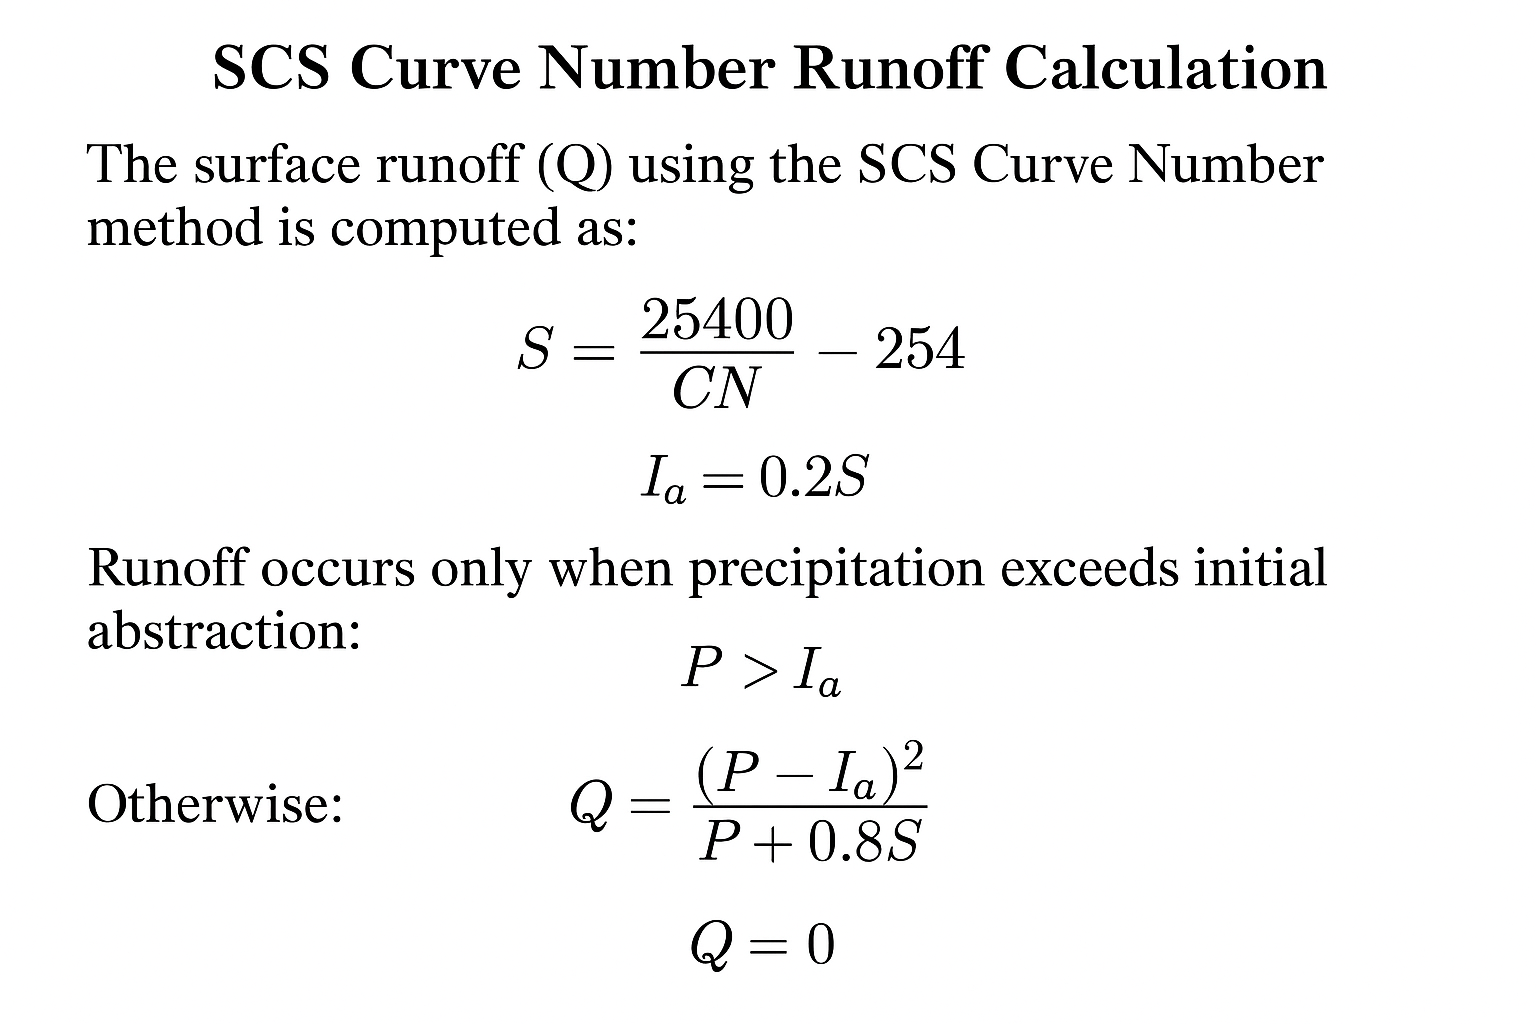

Where:

- \( P \) = precipitation (mm)  
- \( CN \) = Curve Number (dimensionless)  
- \( S \) = potential maximum retention (mm)  
- \( I_a \) = initial abstraction (mm)  
- \( Q \) = direct runoff (mm)


You should edit `cn_lookup` to match your UNet landcover class IDs and appropriate curve numbers.

###  Runoff using Curve Number method
This cell converts landcover classes to CN values via **cn_lookup**, then computes hydrologic runoff using the SCS Curve Number equation. The output runoff and its normalized version are plotted for interpretation.

Runoff computed. Sample stats min/max: 0.0 0.0


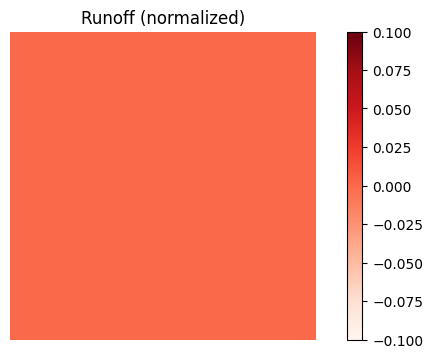

In [ ]:
# 6 — Generate CN map from landcover and compute runoff
# Define a simple lookup: class_id -> CN value (example: 1 = water, 2 = forest, 3 = urban ...)
# Update this mapping based on your UNet classes
cn_lookup = {
    0: 100,  # nodata/undefined -> impermeable (or adjust)
    1: 55,   # example class
    2: 70,
    3: 85,
    4: 60
}

if lc is None or precip is None:
    print('Landcover or precipitation missing — cannot compute runoff. Please provide both and re-run.')
else:
    # Build CN map with default fallback
    cn_map = np.full(lc.shape, 75.0, dtype=np.float32)
    for cls, cn in cn_lookup.items():
        cn_map[lc == cls] = cn

    # SCS Curve Number method
    P = precip.astype(np.float32)  # precipitation in mm (assumed)
    S = (25400.0 / cn_map) - 254.0
    Ia = 0.2 * S

    runoff = np.zeros_like(P, dtype=np.float32)
    mask = (P > Ia)
    runoff[mask] = ((P[mask] - Ia[mask])**2) / (P[mask] + 0.8 * S[mask])

    # Normalize runoff for visualization (0..1)
    runoff_norm = (runoff - np.nanmin(runoff)) / (np.nanmax(runoff) - np.nanmin(runoff) + 1e-8)

    print('Runoff computed. Sample stats min/max:', np.nanmin(runoff), np.nanmax(runoff))
    plt.figure(figsize=(8,4))
    plt.imshow(runoff_norm, cmap='Reds')
    plt.title('Runoff (normalized)')
    plt.colorbar()
    plt.axis('off')
    plt.show()

## 7 — NDVI change detection & habitat quality

Compute NDVI delta (recent - historic). Then convert NDVI to a habitat quality proxy in 0..1 and compute habitat degradation as (1 - quality).

### NDVI change & habitat quality
This computes:
- **NDVI delta** = recent − historic.
- **Habitat quality**: NDVI scaled from [-1,1] → [0,1].
- **Degradation** = 1 − quality.
Plots help interpret vegetation loss or recovery.

NDVI delta stats: -0.87646097 0.3678479


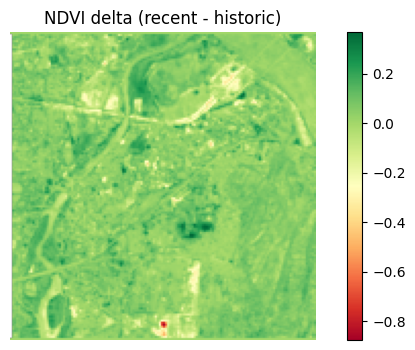

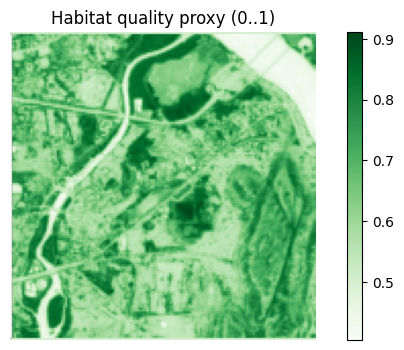

In [ ]:
# 7 — NDVI change and habitat quality
if ndvi_recent is None or ndvi_hist is None:
    print('NDVI rasters missing — cannot compute NDVI change. Provide both and re-run.')
else:
    ndvi_delta = ndvi_recent - ndvi_hist
    # Clip NDVI to realistic bounds
    ndvi_recent_clip = np.clip(ndvi_recent, -1.0, 1.0)

    # Convert NDVI to habitat quality proxy: rescale from [-1,1] to [0,1]
    hab_quality = (ndvi_recent_clip + 1.0) / 2.0
    hab_quality = np.clip(hab_quality, 0.0, 1.0)
    hab_deg = 1.0 - hab_quality

    print('NDVI delta stats:', np.nanmin(ndvi_delta), np.nanmax(ndvi_delta))
    plt.figure(figsize=(8,4))
    plt.imshow(ndvi_delta, cmap='RdYlGn')
    plt.title('NDVI delta (recent - historic)')
    plt.colorbar()
    plt.axis('off')
    plt.show()

    plt.figure(figsize=(8,4))
    plt.imshow(hab_quality, cmap='Greens')
    plt.title('Habitat quality proxy (0..1)')
    plt.colorbar()
    plt.axis('off')
    plt.show()

## 8 — Risk fusion (Hazard × Exposure × Vulnerability)

We compute:
- Hazard: combination of flood_proxy and runoff_norm
- Exposure: simple mask from landcover (e.g., built-up class as exposure) — adjust to your classes
- Vulnerability: habitat degradation (hab_deg) or other metric

Finally, risk = hazard * exposure * vulnerability. All components are normalized 0..1 for comparability.

### Risk fusion
This merges hazard, exposure, and vulnerability:
- Hazard = mean(flood proxy, runoff)
- Exposure = chosen landcover classes (e.g., built‑up)
- Vulnerability = habitat degradation
Risk = H × E × V. The final normalized map is visualized and saved.

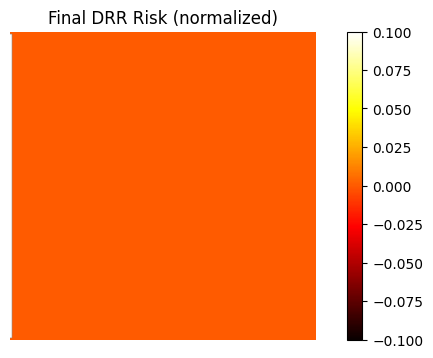

Saved /mnt/data/ecodrr_outputs/flood_proxy.tif
Saved /mnt/data/ecodrr_outputs/runoff.tif
Saved /mnt/data/ecodrr_outputs/ndvi_delta.tif
Saved /mnt/data/ecodrr_outputs/hab_quality.tif
Saved /mnt/data/ecodrr_outputs/risk.tif

Outputs saved to /mnt/data/ecodrr_outputs


In [ ]:
# 8 — Risk fusion
# Define exposure mask — for example assume landcover class 3 = built-up/exposed
exposure_classes = [3]  # edit to match your class id(s)

if 'runoff_norm' not in globals():
    runoff_norm = None

if flood_proxy is None:
    raise SystemExit('Flood proxy missing — run flood proxy cell first')

# Hazard: average of flood_proxy and runoff (if runoff exists)
if runoff_norm is not None:
    hazard = np.nanmean(np.stack([flood_proxy, runoff_norm]), axis=0)
else:
    hazard = flood_proxy.copy()

# Exposure: binary mask where landcover belongs to exposure_classes
if lc is None:
    exposure = np.zeros_like(hazard)
    print('Landcover missing — exposure mask is zero. Provide landcover to compute exposure properly.')
else:
    exposure = np.isin(lc, exposure_classes).astype(float)

# Vulnerability: use habitat degradation if available
if 'hab_deg' in globals():
    vulnerability = hab_deg.copy()
else:
    vulnerability = np.ones_like(hazard) * 0.5  # fallback

# Final risk
risk = hazard * exposure * vulnerability
# Normalize for visualization
risk_norm = (risk - np.nanmin(risk)) / (np.nanmax(risk) - np.nanmin(risk) + 1e-8)

plt.figure(figsize=(8,4))
plt.imshow(risk_norm, cmap='hot')
plt.title('Final DRR Risk (normalized)')
plt.colorbar()
plt.axis('off')
plt.show()

# Save outputs
out_dir = '/mnt/data/ecodrr_outputs'
os.makedirs(out_dir, exist_ok=True)

save_raster(os.path.join(out_dir, 'flood_proxy.tif'), flood_proxy.astype(np.float32), ref_prof)
if 'runoff' in globals() and runoff is not None:
    save_raster(os.path.join(out_dir, 'runoff.tif'), runoff.astype(np.float32), ref_prof)
if 'ndvi_delta' in globals():
    save_raster(os.path.join(out_dir, 'ndvi_delta.tif'), ndvi_delta.astype(np.float32), ref_prof)
if 'hab_quality' in globals():
    save_raster(os.path.join(out_dir, 'hab_quality.tif'), hab_quality.astype(np.float32), ref_prof)
save_raster(os.path.join(out_dir, 'risk.tif'), risk_norm.astype(np.float32), ref_prof)

print('\nOutputs saved to', out_dir)